In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import json
import numpy as np
from matplotlib import pyplot
import xgboost as xgb

/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
case_data = pd.read_csv("../data/case.csv", index_col=False)
print(case_data.shape)
tenacy_data = pd.read_csv("../data/tenancy.csv", index_col=False)
print(tenacy_data.shape)
vulnerability_data = pd.read_csv("../data/vulnerability.csv", index_col=False)
print(vulnerability_data.shape)

(46301, 7)
(11102, 4)
(4315, 2)


# Functions

In [ ]:
def transform_list(input_list:list, trans_dict:dict):
    trans_list = [trans_dict[elem] for elem in input_list]
    return list( set(trans_list))

# Vulnerability

In [3]:
# Vulnerability
vulnerability_data
print("There are {} tenants in our database".format(vulnerability_data['tenancy_id'].drop_duplicates().shape[0]))
print("Each tenant can have more than one vulnerability")
vulnerability_data['Vulnerability'].value_counts()

There are 2683 tenants in our database
Each tenant can have more than one vulnerability


Illness                  914
Physical Support         668
Mental Health            538
Elderly                  391
COVID Self Isolation     299
Tenancy Support          211
Caution                  173
Wheelchair Support       171
Language Support         166
Learning difficulties    156
Tenancy Verification     139
Sight                    136
COVID 12wk Shielding     125
Hearing                  111
Domestic Violence         53
Drug/Alcohol              51
Young Person              11
Child Protection           2
Name: Vulnerability, dtype: int64

I grouped together the vulnerabilities into categories, because I though that movement vulnerabilities could impact more someone from cleaning their apartment therefore increase the chance of mould.

Below there are two different groupings that I came with

In [1]:
# Groupng 1
diff_dict = {'movement_difficulty': ['Physical Support', 'Elderly', 'Wheelchair Support', 'Sight'],
 'health_risk': ['COVID 12wk Shielding'],
 'communication_difficulty': ['Language Support', 'Hearing'],
 'mental_difficulty': ['Mental Health', 'Learning difficulties', 'Drug/Alcohol', 'Domestic Violence'],
 'temp_vulnerability': ['COVID Self Isolation', 'Tenancy Verification'],
 'generic': ['Illness', 'Caution', 'Young Person', 'Child Protection', 'Tenancy Support']
             }
# I have to understand bettter what is tenacy support and tenacy verifications

In [2]:
# Grouping 2
diff_dict2 = {'movement_difficulty': ['Physical Support', 'Elderly', 'Wheelchair Support'], # people who can not clean because of physical barriers
             'covid': ['COVID 12wk Shielding', 'COVID Self Isolation'], #
             'communication_difficulty': ['Language Support', 'Hearing', 'Sight'],
             'mental_difficulty': ['Mental Health',],
             'abuse_addiction' : ['Drug/Alcohol', 'Domestic Violence'],
              'family_difficulty' : ['Young Person', 'Child Protection'],
              'generic': ['Illness', 'Caution', 'Tenancy Verification'],
              'other' : ['Tenancy Support', 'Learning difficulties']
}

In [5]:
# Dictionary with vulnerability as key and the type of vulnerability (eg. movement difficulty) as value
difficulty_type_dict = {}
for key,value in diff_dict.items():
    for elem in value:
        difficulty_type_dict[elem] = key
print(len(difficulty_type_dict))

difficulty_type_dict2 = {}
for key,value in diff_dict2.items():
    for elem in value:
        difficulty_type_dict2[elem] = key
print(len(difficulty_type_dict2))

18
18


In [9]:
# Transform the format of the data so all the vulnerabilites of a tenant is in the same row
vulnerability_type = 'v2'
vulnerability_data_packed = vulnerability_data.groupby(['tenancy_id'])['Vulnerability'].apply(list).reset_index()
vulnerability_data_packed
# Assign type of disease for each submisison
if vulnerability_type == 'v1':
    vulnerability_data_packed['Vulnerability type'] = vulnerability_data_packed['Vulnerability'].apply(lambda x : transform_list(x, difficulty_type_dict))
elif vulnerability_type == 'v2':
    vulnerability_data_packed['Vulnerability type'] = vulnerability_data_packed['Vulnerability'].apply(lambda x : transform_list(x, difficulty_type_dict2))

In [10]:
vulnerability_data_packed.head()

,tenancy_id,Vulnerability,Vulnerability type
0,Tenant1000,[COVID Self Isolation],[covid]
1,Tenant10006,"[COVID Self Isolation, COVID Self Isolation]",[covid]
2,Tenant10025,[Language Support],[communication_difficulty]
3,Tenant1003,"[Illness, Physical Support, Sight, Mental Health]","[movement_difficulty, communication_difficulty..."
4,Tenant10039,[Mental Health],[mental_difficulty]


# Tenacy

In [11]:
def estimate_date_from_days(days):
    (year, days_remaining) =  divmod(days, 365)
    (months, days_remaining) = divmod(days_remaining, 30)
    days = days_remaining
    return f'{year} years, {months} months, {days} days'

In [12]:
# New columns
tenacy_data['tenancy_start_date_as_date'] = tenacy_data['tenancy_start_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date'].apply(lambda x :  x if str(x) == 'nan' else datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['Status'] =tenacy_data['tenancy_end_date'].apply(lambda x : "Open" if str(x) == 'nan' else 'Closed')
tenacy_data['tenancy_duration (days)'] = tenacy_data.apply(lambda row : (datetime.now() - row['tenancy_start_date_as_date']).days if str(row['tenancy_end_date']) == 'nan' else (row['tenancy_end_date_as_date'] - row['tenancy_start_date_as_date']).days, axis =1 )
tenacy_data['tenacy_duration (months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/30,0))
tenacy_data['tenacy_duration (6- months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/180,0))
tenacy_data['tenacy_duration (years)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/365,0))

In [13]:
# Tenacy (historical table)
tenacy_data.sort_values(['unit_ref', 'tenancy_start_date'])

print("There are {} properties in our database".format(tenacy_data['unit_ref'].drop_duplicates().shape[0]))
print("There are {} active contracts".format(tenacy_data[tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("There are {} closed contracts".format(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("The median duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].median())))
print("The mean duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].mean())))
# number of open contracts
# number of closed contracts
# average duration of contract
# check that there are not tenants leaving in the same apartment

There are 9956 properties in our database
There are 9404 active contracts
There are 1698 closed contracts
The median duration of closed contracts is 6.0 years, 1.0 months, 19.0 days
The mean duration of closed contracts is 8.0 years, 11.0 months, 28.63309776207325 days


In [14]:
# More than one tenants living in the same apartment
coliving_tenants = tenacy_data.groupby(['unit_ref', 'tenancy_start_date'])[['tenancy_id']].count().sort_values('tenancy_id', ascending = False)#[]#['tenancy_start_date'].max()
coliving_tenants[coliving_tenants['tenancy_id'] > 1]

,,tenancy_id
unit_ref,tenancy_start_date,
Unit6829,22/08/2019,2
Unit7757,13/11/2020,2
Unit9601,12/11/2018,2


In [15]:
# Sequence of tenants living in the apartment # TODO - this can be used as a feature but careful with merging - use timestamp as well
tenancy_chain = (tenacy_data.groupby(['unit_ref']).agg({'tenancy_id': lambda x: ', '.join(x)}).reset_index()
                 .rename(columns = {'tenancy_id' : 'sequence_of_tenants'}))
tenancy_chain['number_of_tenants'] = tenancy_chain['sequence_of_tenants'].apply(lambda x : len(x.split(',')))
# tenancy_chain.sort_values('number_of_tenants', ascending = False)
tenancy_chain['number_of_tenants'].value_counts()

1    8856
2    1058
3      38
4       4
Name: number_of_tenants, dtype: int64

In [16]:
tenancy_chain.sort_values('number_of_tenants', ascending = False)

,unit_ref,sequence_of_tenants,number_of_tenants
6044,Unit6460,"Tenant5001, Tenant5002, Tenant5003, Tenant5004",4
1114,Unit2005,"Tenant7503, Tenant7504, Tenant7505, Tenant7506",4
7238,Unit7544,"Tenant913, Tenant914, Tenant915, Tenant916",4
5571,Unit6033,"Tenant2458, Tenant2459, Tenant2460, Tenant2461",4
9044,Unit9175,"Tenant4071, Tenant4072, Tenant4073",3
...,...,...,...
3502,Unit4166,Tenant10124,1
3503,Unit4167,Tenant10651,1
3504,Unit4168,Tenant2229,1
3505,Unit4169,Tenant10866,1


## Tenacy duration distributions

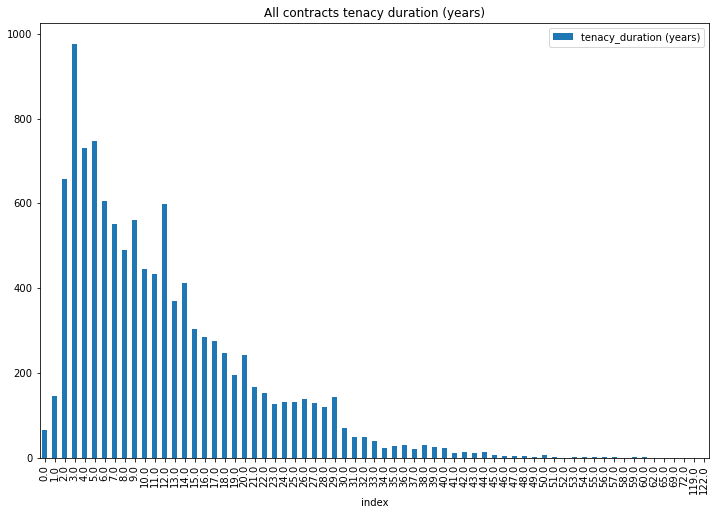

In [17]:
tenacy_data['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "All contracts tenacy duration (years)")

In [18]:
print(tenacy_data.shape[0], tenacy_data.drop_duplicates(subset = ['tenancy_id']).shape[0])

11102 11102


In [19]:
# Each tenant has only lived to one apartment
tenacy_data.groupby(['tenancy_id'])['unit_ref'].count().reset_index().sort_values('unit_ref', ascending = False).head()

,tenancy_id,unit_ref
0,Tenant0,1
7405,Tenant6671,1
7397,Tenant6664,1
7398,Tenant6665,1
7399,Tenant6666,1


(1698, 11)


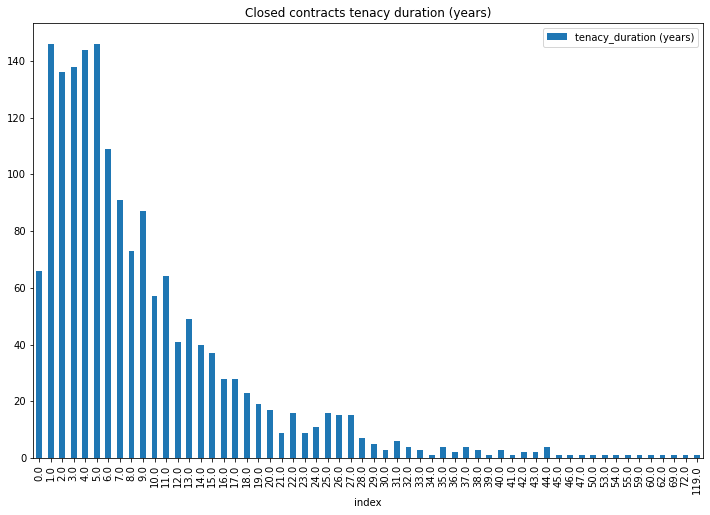

In [20]:
# Closed contracts
closed_contracts = tenacy_data[tenacy_data['Status'] == 'Closed']
print(closed_contracts.shape)
closed_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Closed contracts tenacy duration (years)")

(9404, 11)


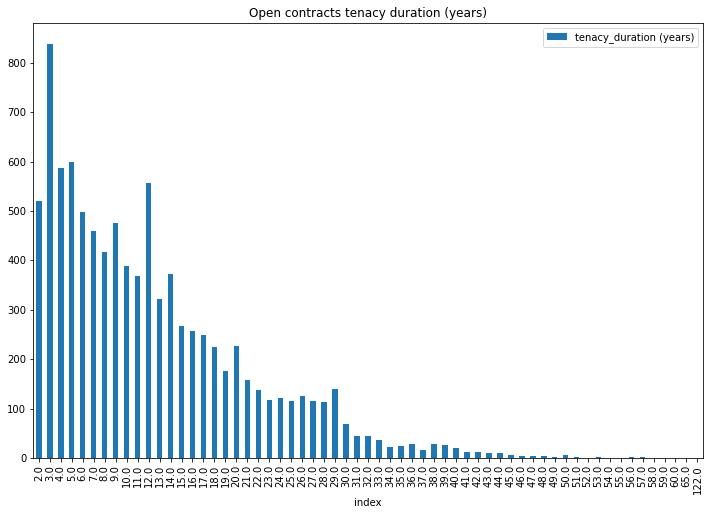

In [21]:
# Open contracts
open_contracts = tenacy_data[tenacy_data['Status'] == 'Open']
print(open_contracts.shape)
open_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Open contracts tenacy duration (years)")

# Case data

In [22]:
case_data.head()
# which cases closes more effectively

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date
0,Case0,Unit8230,2005.0,Resolved,ASB,NaN,21/02/2019 10:20
1,Case1,Unit7377,1880.0,Resolved,Service Charges,Invoice/Breakdown Request,20/05/2019 08:23
2,Case2,Unit2402,2008.0,Resolved,ASB,NaN,20/05/2019 08:47
3,Case3,Unit9567,1935.0,Resolved,Query,NaN,20/05/2019 08:55
4,Case4,Unit7956,2014.0,Resolved,Query,NaN,20/05/2019 09:04


In [23]:
case_data['quarter'] = pd.PeriodIndex(case_data.case_create_date, freq='Q')

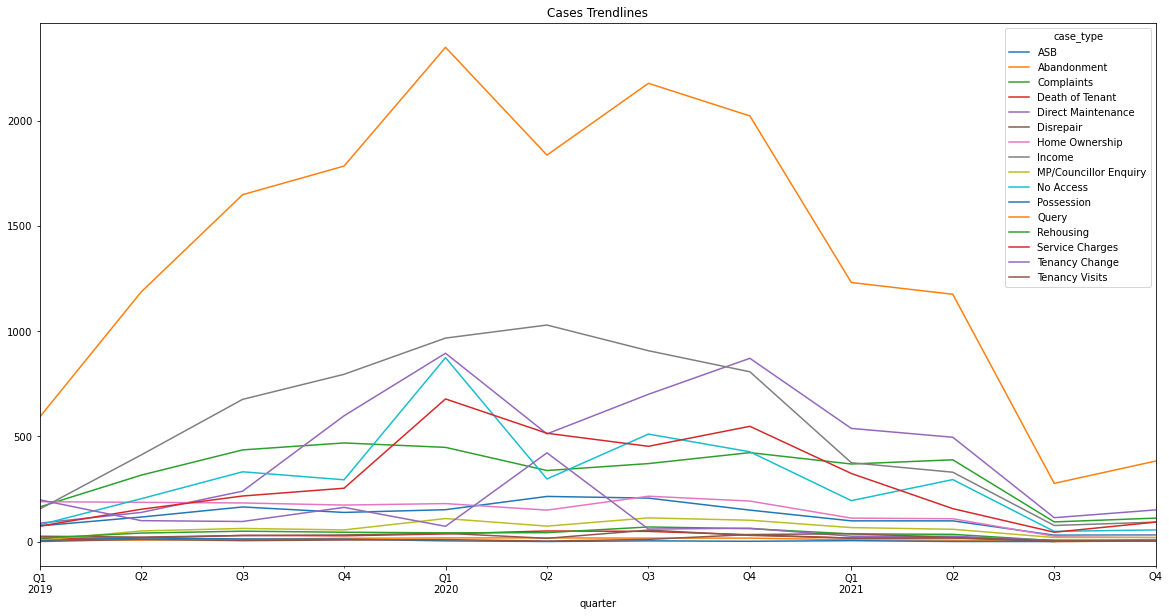

In [24]:
pd.pivot_table(case_data, index='case_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (20,10), title="Cases Trendlines")

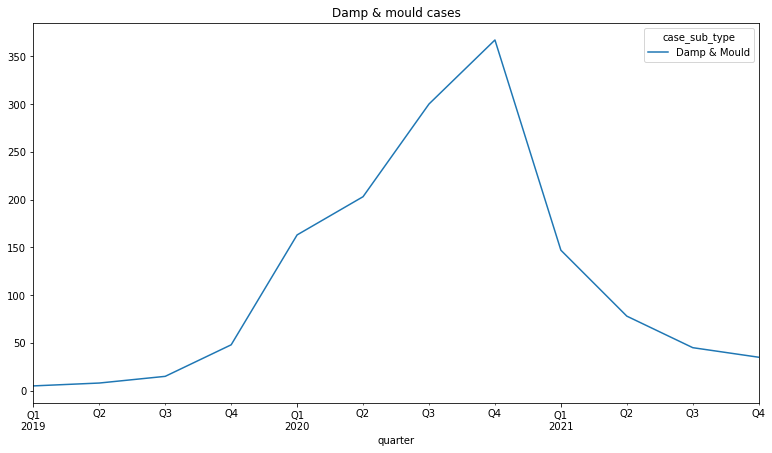

In [25]:
pd.pivot_table(case_data[case_data['case_sub_type'] == 'Damp & Mould'], index='case_sub_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (13,7), title="Damp & mould cases")
# It looks like this graph is the merging of increase of mould during colder months and covid

In [26]:
# Merge cases and tenancy datasets

# Set as closing date the current date for the open contracts so that we can do comparisons with end date
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date_as_date'].apply(lambda x : datetime.now() if str(x) == 'NaT' else x)

# Filter out wrong rows that came out of the merging
print(case_data.shape, tenacy_data.shape)
units_cases_df =case_data.merge(tenacy_data, on = 'unit_ref')
units_cases_df = units_cases_df[units_cases_df['case_create_date'] >= units_cases_df['tenancy_start_date_as_date']]
units_cases_df = units_cases_df[units_cases_df['case_create_date'] <= units_cases_df['tenancy_end_date_as_date']]
print(units_cases_df.shape)

units_cases_df['case_create_date_as_date'] = units_cases_df['case_create_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y %H:%M'))
units_cases_df['time_until_the_case (days)'] = units_cases_df.apply(lambda row :( row['case_create_date_as_date'] - row['tenancy_start_date_as_date']).days, axis = 1 )

(46301, 8) (11102, 11)
(45173, 18)


In [27]:
# Merge unit_cases with vulnerability
units_cases_df = units_cases_df.merge(vulnerability_data_packed, on = 'tenancy_id', how= 'left')

# Add features
units_cases_df['number of vulnerabilities'] = units_cases_df['Vulnerability'].apply(lambda x : 0 if str(x) == 'nan' else len(x))
units_cases_df['Vulnerability'] = units_cases_df['Vulnerability'].apply(lambda x : x if isinstance(x, list) else ['Healthy'])
units_cases_df['Vulnerability type'] = units_cases_df['Vulnerability type'].apply(lambda x : x if isinstance(x, list) else ['No vulnerability'])

# Month of the case (possibly during winter periods Damp is a most common phenomenon
units_cases_df['case_month'] = units_cases_df['case_create_date_as_date'].apply(lambda x : x.month)

# Fillnas with mean built year value
mean_build_year = int(units_cases_df.dropna(subset = ['unit_build_year'])['unit_build_year'].mean())
units_cases_df['unit_build_year'].fillna(mean_build_year, inplace= True)

# Label
units_cases_df['label'] = units_cases_df['case_sub_type'].apply(lambda x : 1 if x == 'Damp & Mould' else 0)

In [28]:
# Duplicated case numbers because some tenants are leaving together
units_cases_df[units_cases_df['case_number'].duplicated()]

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date,quarter,tenancy_id,tenancy_start_date,...,tenacy_duration (months),tenacy_duration (6- months),tenacy_duration (years),case_create_date_as_date,time_until_the_case (days),Vulnerability,Vulnerability type,number of vulnerabilities,case_month,label
15755,Case41027,Unit9707,2015.0,Resolved,Query,NaN,13/11/2019 13:38,2019Q4,Tenant8463,04/11/2019,...,33.0,6.0,3.0,2019-11-13 13:38:00,9,[Healthy],[No vulnerability],0,11,0
15757,Case41429,Unit9707,2015.0,Resolved,Query,NaN,20/11/2019 11:24,2019Q4,Tenant8463,04/11/2019,...,33.0,6.0,3.0,2019-11-20 11:24:00,16,[Healthy],[No vulnerability],0,11,0
31596,Case45024,Unit131,1890.0,Resolved,ASB,NaN,21/01/2020 09:43,2020Q1,Tenant7054,20/01/2020,...,31.0,5.0,3.0,2020-01-21 09:43:00,1,[Healthy],[No vulnerability],0,1,0
34269,Case12553,Unit8541,1974.0,Resolved,Income,Tenancy Enquiry,10/07/2020 15:27,2020Q4,Tenant1492,16/11/2018,...,45.0,8.0,4.0,2020-07-10 15:27:00,602,[Healthy],[No vulnerability],0,7,0
34271,Case19118,Unit8541,1974.0,Resolved,Income,Refund Enquiry,05/10/2020 14:02,2020Q2,Tenant1492,16/11/2018,...,45.0,8.0,4.0,2020-10-05 14:02:00,689,[Healthy],[No vulnerability],0,10,0
39044,Case17886,Unit9601,2018.0,Resolved,Income,Refund Enquiry,21/09/2020 14:21,2020Q3,Tenant3726,12/11/2018,...,45.0,8.0,4.0,2020-09-21 14:21:00,679,[Healthy],[No vulnerability],0,9,0
40208,Case19542,Unit6829,2018.0,Resolved,Income,Refund Enquiry,08/10/2020 11:46,2020Q3,Tenant3107,22/08/2019,...,36.0,6.0,3.0,2020-10-08 11:46:00,413,[Healthy],[No vulnerability],0,10,0


# Training - Testing

In [29]:
def one_hot_encode_list(df:pd.DataFrame, column:str):
    binarizer = MultiLabelBinarizer().fit(df[column])
    vector_df = pd.DataFrame(binarizer.transform(df[column]), columns=binarizer.classes_)

    return vector_df

In [30]:
key = ['case_number', 'tenancy_id']
train_cols = ['unit_build_year', 'tenancy_duration (days)', 'time_until_the_case (days)', 'Vulnerability', 'number of vulnerabilities', 'case_month']
test_cols = ['label']

# Features and label
X = units_cases_df[train_cols]
y = units_cases_df['label']

# One hot encode vulnerability
X = X.join(one_hot_encode_list(units_cases_df, 'Vulnerability')).drop(columns = ['Vulnerability'])

# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Number of "Damp and Mould" that we have in the training and test set
print(y_train.sum(), y_test.sum())

1006 401


# Classifier

In [31]:
def read_json_as_dict(json_file_name:str):
    with open(json_file_name) as d:
        dict_name = json.load(d)
    return dict_name

def save_dict_as_json(json_file_name:str, dict_to_save:dict):
    with open(json_file_name, "w") as outfile:
        json.dump(dict_to_save, outfile)

def save_accuracy_to_dict(input_dict:dict, model:str, features_list:list):
    try:
        dict_to_save_outputs[model]
    except:
        dict_to_save_outputs[model] = {}
    finally:
        dict_to_save_outputs[model][str(features_list)] = accuracy
    return dict_to_save_outputs

In [32]:
try:
    dict_to_save_outputs = read_json_as_dict("accuracy_dict.json")
    print("There is an existing dictionary")
except:
    print("There is no existing dictionary")
    dict_to_save_outputs = {}

There is an existing dictionary


In [33]:
features_list = [col for col in train_cols]

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(data_encoded_extended, y['Sub Clusters labels'], test_size=0.2, random_state=0)
for model in ['LR', 'RF']:
    print(model)
    if model == 'LR':
        classifier = LogisticRegression()
    elif model == 'RF':
        classifier = RandomForestClassifier(random_state=7)


    classifier.fit(X_train, y_train)

    # Accuracy
    y_pred = classifier.predict(X_test)
    print(y_pred.shape)

    # Accuracy
    y_pred = classifier.predict(X_test)
    accuracy = round(classifier.score(X_test, y_test), 4)
    print('Accuracy of {} classifier on test set: {:.4f}'.format(model, accuracy))
    dict_to_save_outputs = save_accuracy_to_dict(dict_to_save_outputs, model, features_list)

save_dict_as_json("accuracy_dict.json",dict_to_save_outputs)

LR
(13552,)
Accuracy of LR classifier on test set: 0.9704
RF
(13552,)
Accuracy of RF classifier on test set: 0.9653


In [35]:
# XGBoost
model = 'XGBoost'
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)
# Predict
preds = xgb_cl.predict(X_test)
# Score
accuracy = round(classifier.score(X_test, y_test), 4)
print('Accuracy of {} classifier on test set: {:.4f}'.format(model, accuracy))
dict_to_save_outputs = save_accuracy_to_dict(dict_to_save_outputs, model, features_list)
save_dict_as_json("accuracy_dict.json",dict_to_save_outputs)

/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:38:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost classifier on test set: 0.9653


## XGBoost

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
from xgboost import XGBClassifier

In [38]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [2,8,10, 20],
    'n_estimators': [5, 20, 50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use

[18:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale

In [39]:
grid_search.best_estimator_c

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
xgbc = XGBClassifier(max_depth = 8, n_estimators=200, learning_rate=0.1)

xgbc.fit(X_train, y_train)
ypred = xgbc.predict(X_test)
accuracy = round(classifier.score(X_test, y_test), 4)
print('Accuracy of XGBoost classifier on test set: {:.4f}'.format(accuracy))

/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:03:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost classifier on test set: 0.9653


In [37]:
y_train

15572    0
4459     0
12986    0
37674    0
26085    0
        ..
11284    0
44732    0
38158    0
860      0
15795    0
Name: label, Length: 31621, dtype: int64

# Feature Importance

Feature 0: unit_build_year, Score :0.1619
Feature 1: tenancy_duration (days), Score :0.2881
Feature 2: time_until_the_case (days), Score :0.3949
Feature 3: number of vulnerabilities, Score :0.0149
Feature 4: case_month, Score :0.1001
Feature 5: No vulnerability, Score :0.0028
Feature 6: abuse_addiction, Score :0.0021
Feature 7: communication_difficulty, Score :0.0047
Feature 8: covid, Score :0.0053
Feature 9: family_difficulty, Score :0.0006
Feature 10: generic, Score :0.0075
Feature 11: mental_difficulty, Score :0.0058
Feature 12: movement_difficulty, Score :0.0065
Feature 13: other, Score :0.0049


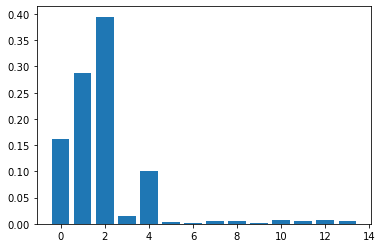

In [46]:
# Random Forest - Feature Importance

importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print("Feature {}: {}, Score :{:.4f}".format(i,X.columns[i],v))
    # print('Feature: {} , Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [47]:
features_names = list(X.columns)
Feataure_Importance_df = pd.DataFrame(list(zip(features_names, list(importance))), columns = ['Feature', "Importance"])
Feataure_Importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
2,time_until_the_case (days),0.394891
1,tenancy_duration (days),0.288111
0,unit_build_year,0.161858
4,case_month,0.100104
3,number of vulnerabilities,0.014868
10,generic,0.007498
12,movement_difficulty,0.006459
11,mental_difficulty,0.005818
8,covid,0.005306
13,other,0.004867


# Probability Estimation

In [49]:
# Random Forest
labels_mapping = pd.DataFrame(classifier.classes_).reset_index().rename(columns = {'index': 'classifier_numbers', 0: 'labels'})
labels_dict = dict(zip(labels_mapping['classifier_numbers'], labels_mapping['labels']))
proba_with_labels = pd.DataFrame(classifier.predict_proba(X_test)).rename(columns = labels_dict)

# Misclassified data

In [58]:
test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = y_pred
test_df['Label 0'] = np.array(proba_with_labels[0])
test_df['Label 1'] = np.array(proba_with_labels[1])
test_df[test_df['Actual'] != test_df['Predicted']]

,unit_build_year,tenancy_duration (days),time_until_the_case (days),number of vulnerabilities,case_month,No vulnerability,abuse_addiction,communication_difficulty,covid,family_difficulty,generic,mental_difficulty,movement_difficulty,other,Actual,Predicted,Label 0,Label 1
17874,1964.0,1690,1086,0,12,1,0,0,0,0,0,0,0,0,1,0,0.56,0.44
16274,1997.0,8991,8380,0,11,1,0,0,0,0,0,0,0,0,1,0,0.99,0.01
35011,2006.0,2369,1782,1,12,0,0,0,0,0,0,0,1,0,0,1,0.35,0.65
22605,2005.0,6009,5216,0,5,1,0,0,0,0,0,0,0,0,0,1,0.48,0.52
41408,1890.0,12855,12419,1,5,0,0,1,0,0,0,0,0,0,0,1,0.39,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30159,1998.0,6128,5392,3,7,0,0,0,1,0,1,0,1,0,1,0,1.00,0.00
36566,1900.0,4399,3809,0,12,1,0,0,0,0,0,0,0,0,0,1,0.45,0.55
30078,2014.0,2880,2240,3,10,0,0,1,0,0,1,0,1,0,1,0,0.99,0.01
12052,1890.0,1277,625,3,10,0,0,0,0,0,1,1,1,0,1,0,0.99,0.01


In [ ]:
# Which feature impact the maintenance of the building?
# 1. Vulnerability of the tenant (some of them might not allow them to clean the house)
# 2.Number of vulnerabilities that the tenant has
# 3. Duration of tenancy the date that the case is monitored ( not sure how)
# 4. How usual do the tenant use the L&Q apartments - if they do it usually probably they do not create any problems
# 5. Average time that a tenant lives to an apartment
# 6. unit built year (because the case data is just from the last 2 years it make no sense to substract mould_case_date - unit_built_year
# 7. add month of case (summer months, winter months)

# External data that would help:
# Other important info
# I do not see much seasonality (covid related)
# temperature in london
# area of the apartment is missing
# floor of apartent and type of apartment
# how many people are living in the apartment